In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
!unzip /content/drive/MyDrive/Dataset/drive-download-20240413T054121Z-001.zip

Archive:  /content/drive/MyDrive/Dataset/drive-download-20240413T054121Z-001.zip
  inflating: test/diseased cotton leaf/dis_leaf (124).jpg  
  inflating: test/diseased cotton leaf/dis_leaf (248).jpg  
  inflating: test/diseased cotton plant/dd (706).jpg  
  inflating: test/diseased cotton plant/dd (513).jpg  
  inflating: test/diseased cotton leaf/dis_leaf (322).jpg  
  inflating: test/fresh cotton plant/dsd (600).jpg  
  inflating: test/fresh cotton plant/dsd (632).jpg  
  inflating: test/diseased cotton plant/dd (328).jpg  
  inflating: test/fresh cotton plant/dsd (405).jpg  
  inflating: test/diseased cotton plant/dd (41).jpg  
  inflating: test/fresh cotton leaf/d (341).jpg  
  inflating: test/fresh cotton plant/dsd (223).jpg  
  inflating: test/fresh cotton leaf/d (396).jpg  
  inflating: test/test data comp files/d (396)_compressed.jpg  
  inflating: test/test data comp files/d (378)_compressed.jpg  
  inflating: test/test data comp files/dis_leaf (322)_compressed.jpg  
  inflati

In [ ]:
train_data_path="/content/train"
validation_data_path="/content/val"

In [ ]:
#--- Show Augmrnted Image

def plotimages(images_arr):
    fig,axes=plt.subplots(1,5,figsize=(20,20))
    axes= axes.flatten()
    for img ,ax in zip(images_arr,axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


In [ ]:
# Augmentation Image Generator it will be use for traing
#---- it generates more images using below parameters..


train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=40,width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

In [ ]:
# This is a Generator that will read pictures found in
# at train_data_path ,and Generates batches of augmented image data..

train_data=train_datagen.flow_from_directory(train_data_path,
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='categorical')

Found 1951 images belonging to 4 classes.


In [ ]:
train_data.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [ ]:
#--- This is Augmentation conf. we will use for validation

val_datagen=ImageDataGenerator(rescale=1./255)



#---This is Generator for Validation data

Val_data=val_datagen.flow_from_directory(validation_data_path,
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode='categorical')

Found 324 images belonging to 4 classes.


In [ ]:
Val_data.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

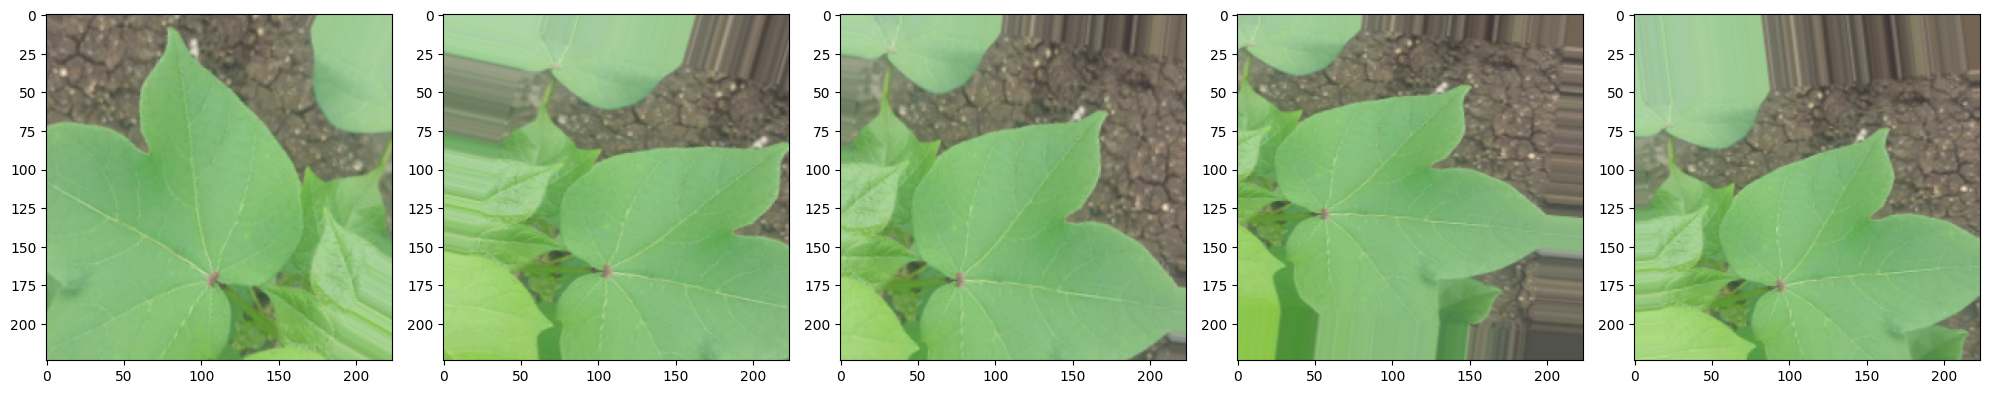

In [ ]:
images=[train_data[0][0][0] for i in range(6)]

plotimages(images)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint path (use .keras or .h5)
model_path = "/content/saved_model.keras"  # or "/content/saved_model.h5"

# Create ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor="val_accuracy",  # Monitor validation accuracy
    verbose=1,
    save_best_only=True,  # Save only the best model
    mode="max"  # Maximize val_accuracy
)

# Add the checkpoint to the callbacks list
callbacks_list = [checkpoint]

In [ ]:
# 3. Load ResNet152V2 Pre-trained Model
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# 4. Build the Model
model = Sequential([
    base_model,  # Add the pre-trained ResNet152V2 model as the base
    GlobalAveragePooling2D(),  # Pooling layer to reduce the spatial dimensions
    Dense(512, activation='relu'),  # Dense layer with ReLU activation
    Dense(train_data.num_classes, activation='softmax')  # Final output layer for multiclass classification
])

In [ ]:
# Freeze the base model layers to avoid training them (for transfer learning)
base_model.trainable = False



In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Learning rate for Adam optimizer
    loss='categorical_crossentropy',  # Loss function for multiclass classification
    metrics=['accuracy']  # Metric to evaluate the model's performance
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,382,788 (226.53 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [ ]:
# 6. Train the Model
result = model.fit(
    train_data,
    validation_data=Val_data,
    epochs=20,  # Number of epochs to train
    steps_per_epoch=len(train_data),  # Number of steps per epoch
    validation_steps=len(Val_data),  # Number of validation steps
    verbose=1  # Display training progress
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 887ms/step - accuracy: 0.5711 - loss: 1.0187 - val_accuracy: 0.8333 - val_loss: 0.5775
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 52s 590ms/step - accuracy: 0.8650 - loss: 0.4424 - val_accuracy: 0.8858 - val_loss: 0.4225
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 513ms/step - accuracy: 0.8797 - loss: 0.3812 - val_accuracy: 0.9043 - val_loss: 0.3173
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 34s 559ms/step - accuracy: 0.9195 - loss: 0.2866 - val_accuracy: 0.9167 - val_loss: 0.2685
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 44s 604ms/step - accuracy: 0.9327 - loss: 0.2277 - val_accuracy: 0.9290 - val_loss: 0.2403
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 36s 580ms/step - accuracy: 0.9132 - loss: 0.2668 - val_accuracy: 0.9290 - val_loss: 0.2073
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 514ms/step - accuracy: 0.9208 - loss: 0.2144 - val_accuracy: 0.9321 - val_loss: 0.1924
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 510ms/step - accuracy: 0.9230 - loss: 0.2087 - val_accu

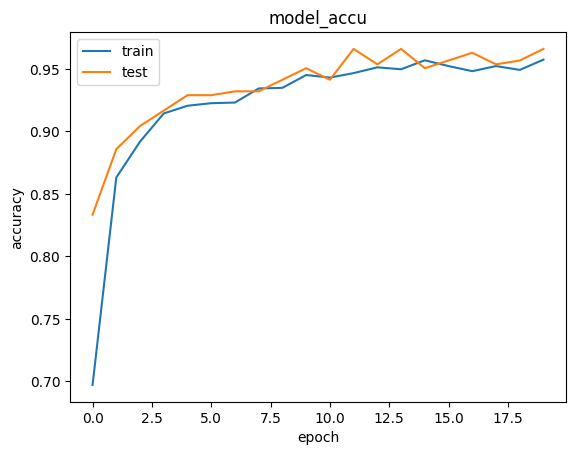

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model_accu')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["train","test"],loc='upper left')

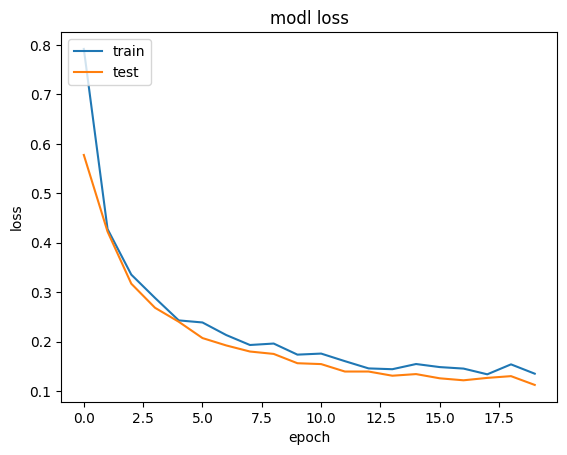

In [ ]:
#plot of loss vs val_loss

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('modl loss')
plt.ylabel("loss")
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
y_pred = model.predict(Val_data)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = Val_data.classes

# Calculate precision
precision = precision_score(y_true, y_pred_classes, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred_classes, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step
Precision: 0.25
Recall: 0.25
F1 Score: 0.25
ROC AUC Score: 0.5004431194436492


In [ ]:
#--- CLASSIFICATION REPORT CONTAINING RECALL,PRECISION AND F1 SCORE VALUE